# PeakVI: Analyzing scATACseq data
PeakVI is used for analyzing scATACseq data. This tutorial walks through how to read, set-up and train the model, accessing and visualizing the latent space, and differential accessibility. We use the 5kPBMC sample dataset from 10X but these steps can be easily adjusted for other datasets.



In [1]:
import sys

# If True, will install via pypi, else will install from source
stable = False
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

     |████████████████████████████████| 61kB 6.0MB/s 
ERROR: nbclient 0.5.3 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 122kB 19.7MB/s 
     |████████████████████████████████| 245kB 41.7MB/s 
     |████████████████████████████████| 204kB 54.0MB/s 
     |████████████████████████████████| 634kB 55.8MB/s 
     |████████████████████████████████| 81kB 10.7MB/s 
     |████████████████████████████████| 839kB 51.1MB/s 
     |████████████████████████████████| 3.2MB 51.1MB/s 
     |████████████████████████████████| 10.3MB 52.9MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 8.7MB 26.2MB/s 
     |████████████████████████████████| 2.4MB 40.5MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |█████████████████████████

First we need to download the sample data. This block will do this for a google colab session, but if you're running it in a different platform you might need to adjust it, or download and unpack the data manually.

In [2]:
!wget https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_5k_nextgem/atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz
!sudo tar -xvf atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz


--2021-04-08 01:58:56--  https://cf.10xgenomics.com/samples/cell-atac/1.2.0/atac_pbmc_5k_nextgem/atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114015463 (109M) [application/x-tar]
Saving to: ‘atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz’

atac_pbmc_5k_nextge 100%[===================>] 108.73M  63.0MB/s    in 1.7s    

2021-04-08 01:58:58 (63.0 MB/s) - ‘atac_pbmc_5k_nextgem_filtered_peak_bc_matrix.tar.gz’ saved [114015463/114015463]

filtered_peak_bc_matrix/
filtered_peak_bc_matrix/matrix.mtx
filtered_peak_bc_matrix/peaks.bed
filtered_peak_bc_matrix/barcodes.tsv


In [3]:
import scvi
import anndata
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import random
random.seed(420)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## loading data 
PeakVI expects as input an AnnData object with a cell-by-region matrix. There are various pipelines that handle preprocessing of scATACseq to obtain this matrix from the sequencing data. If the data was generated by 10X genomics, this matrix is among the standard outputs of CellRanger. Other pipelines, like [SnapATAC](https://github.com/r3fang/SnapATAC/) and [ArchR](https://www.archrproject.com/bookdown/add-peak-matrix.html), also generate similar matrices.

In the case of 10X data, PeakVI has a special reader function `scvi.data.read_10x_atac` that reads the files and creates an AnnData object, demonstrated below. For conveniece, we also demonstrate how to initialize an AnnData object from scratch.

Throughout this tutorial, we use [sample scATACseq data from 10X of 5K PBMCs](https://support.10xgenomics.com/single-cell-atac/datasets/1.2.0/atac_pbmc_5k_nextgem).

In [4]:
# read the count matrix into a sparse matrix, and the cell and region annotations as pandas DataFrames
counts = scipy.io.mmread("filtered_peak_bc_matrix/matrix.mtx").T
regions = pd.read_csv("filtered_peak_bc_matrix/peaks.bed", sep='\t', header=None, names=['chr','start','end'])
cells = pd.read_csv("filtered_peak_bc_matrix/barcodes.tsv", header=None, names=['barcodes'])

# then initialize a new AnnData object
adata = anndata.AnnData(X=counts, obs=cells, var=regions)

# or use this methods to read 10x data directly
adata = scvi.data.read_10x_atac("filtered_peak_bc_matrix")

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


we can use scanpy functions to handle, filter, and manipulate the data. In our case, we might want to filter out peaks that are rarely detected, to make the model train faster:

In [5]:
print(adata.shape)
# compute the threshold: 5% of the cells
min_cells = int(adata.shape[0] * 0.05)
# in-place filtering of regions
sc.pp.filter_genes(adata, min_cells=min_cells)
print(adata.shape)

(4585, 115554)
(4585, 33142)


## set up, training, saving, and loading
We can now set up the AnnData object, which will ensure everything the model needs is in place for training. 

This is also the stage where we can condition the model on additional covariates, which encourages the model to remove the impact of those covariates from the learned latent space. Our sample data is a single batch, so we won't demonstrate this directly, but it can be done simply by setting the `batch_key` argument to the annotation to be used as a batch covariate (must be a valid key in `adata.obs`) .

In [6]:
scvi.data.setup_anndata(adata)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 4585 cells, 33142 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


We can now create a PeakVI model object and train it!

**Importantly**: the default max epochs is set to 500, but in practice PeakVI stops early once the model converges, which rarely requires that many, especially for large datasets (which require fewer epochs to converge, since each epoch includes letting the model view more data). 
*So the estimated runtime is usually a substantial overestimate of the actual runtime.*
In the case of the data we use for this tutorial, it used less than half of the max epochs!

In [7]:
pvi = scvi.model.PEAKVI(adata)
pvi.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2/500:   0%|          | 1/500 [00:01<11:11,  1.35s/it, loss=2.6e+08, v_num=1]

/usr/local/lib/python3.7/dist-packages/scvi/train/_callbacks.py:93: RuntimeWarning: Can save best module state only with reconstruction_loss_validation available, skipping.
  RuntimeWarning,


Epoch 270/500:  54%|█████▍    | 270/500 [04:44<04:02,  1.05s/it, loss=1.93e+08, v_num=1]


since training a model can take a while, we recommend saving the trained model after training, just in case.

In [8]:
pvi.save("trained_model", overwrite=True)

We can then load the model later, which require providing an AnnData object that is structured similarly to the one used for training (or, in most cases, the same one):

In [9]:
pvi = scvi.model.PEAKVI.load("trained_model", adata)

INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 4585 cells, 33142 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


## visualizing and analyzing the latent space
We can now use the trained model to visualize, cluster, and analyze the data. We first extract the latent representation from the model, and save it back into our AnnData object:

In [10]:
latent = pvi.get_latent_representation()
adata.obsm["X_PeakVI"] = latent

print(latent.shape)

(4585, 13)


We can now use scanpy functions to cluster and visualize our latent space:

In [11]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(adata, use_rep="X_PeakVI")
# compute the umap
sc.tl.umap(adata, min_dist=0.2)
# cluster the space (we use a lower resolution to get fewer clusters than the default)
sc.tl.leiden(adata, key_added="cluster_pvi", resolution=0.2)

... storing 'chr' as categorical


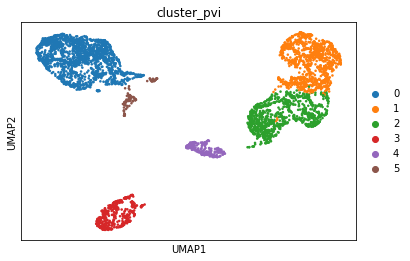

In [12]:
sc.pl.umap(adata, color='cluster_pvi')

## differential accessibility
Finally, we can use PeakVI to identify regions that are differentially accessible. There are many different ways to run this analysis, but the simplest is comparing one cluster against all others, or comparing two clusters to each other. In the first case we'll be looking for marker-regions, so we'll mostly want a one-sided test (the significant regions will only be the ones preferentially accessible in our target cluster). In the second case we'll use a two-sided test to find regions that are differentially accessible, regardless of direction.

We demonstrate both of these next, and do this in two different ways: (1) more convenient but less flexible: using an existing factor to group the cells, and then comparing groups. (2) more flexible: using cell indices directly.

**If the data includes multiple batches**, we encourage setting `batch_correction=True` so the model will sample from multiple batches when computing the differential signal. We do this below despite the data only having a single batch, as a demonstration.

In [13]:
# (1.1) using a known factor to compare two clusters
## two-sided is True by default, but included here for emphasis
da_res11 = pvi.differential_accessibility(groupby='cluster_pvi', group1='3', group2='0', two_sided=True)

# (1.2) using a known factor to compare a cluster against all other clusters
## if we only provide group1, group2 is all other cells by default
da_res12 = pvi.differential_accessibility(groupby='cluster_pvi', group1='3', two_sided=False)

# (2.1) using indices to compare two clusters
## we can use boolean masks or integer indices for the `idx1` and `idx2` arguments
da_res21 = pvi.differential_accessibility(
    idx1 = adata.obs.cluster_pvi == '3',
    idx2 = adata.obs.cluster_pvi == '0',
    two_sided=True,
)
# (2.2) using indices to compare a cluster against all other clusters
## if we don't provide idx2, it uses all other cells as the contrast
da_res22 = pvi.differential_accessibility(
    idx1 = np.where(adata.obs.cluster_pvi == '3'),
    two_sided=False,
)

da_res22.head()

DE...: 100%|██████████| 1/1 [00:11<00:00, 11.35s/it]


,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr1:713460-715296,0.2654,False,-1.018088,0.078080,0.051529,0.645853,0.723933,0.349099,0.400628
chr1:752299-753057,0.0316,False,-3.422488,0.116555,0.053940,0.026689,0.143244,0.011261,0.065202
chr1:762004-763374,0.1122,False,-2.068463,0.190804,0.101724,0.378819,0.569623,0.191441,0.293166
chr1:804843-805776,0.4920,False,-0.032003,-0.055157,-0.032217,0.383930,0.328774,0.195946,0.163729
chr1:839252-841274,0.2762,False,-0.963390,0.044080,0.025464,0.313393,0.357474,0.148649,0.174113


Note that `da_res11` and `da_res21` are equivalent, as are `da_res12` and `da_res22`.
The return value is a pandas DataFrame with the differential results and basic properties of the comparison:

`prob_da` in our case is the probability of cells from cluster 0 being more than 0.05 (the default minimal effect) more accessible than cells from the rest of the data.

`is_da_fdr` is a conservative classification (True/False) of whether a region is differential accessible. This is one way to threshold the results.

`bayes_factor` is a statistical significance score. It doesn't have a commonly acceptable threshold (e.g 0.05 for p-values), bu we demonstrate below that it's well calibrated to the effect size.

`effect_size` is the effect size, calculated as `est_prob1 - est_prob2`.

`emp_effect` is the empirical effect size, calculated as `emp_prob1 - emp_prob2`.

`est_prob{1,2}` are the estimated probabilities of accessibility in group1 and group2.

`emp_prob{1,2}` are the empirical probabilities of detection (how many cells in group X was the region detected in).

We can make sure the probability of DA is well calibrated, and look at the regions that are identified as differentially accessible:

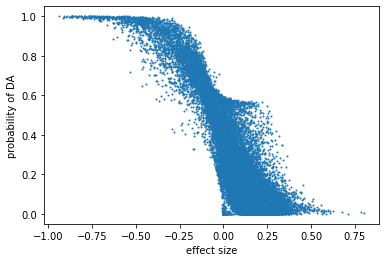

,prob_da,is_da_fdr,bayes_factor,effect_size,emp_effect,est_prob1,est_prob2,emp_prob1,emp_prob2
chr19:5129855-5132436,1.0000,True,18.420681,-0.846021,-0.613032,0.985204,0.139183,0.700450,0.087418
chr22:22522044-22523273,1.0000,True,18.420681,-0.788608,-0.405125,0.899070,0.110463,0.459459,0.054335
chr1:1071624-1073485,1.0000,True,18.420681,-0.664290,-0.333674,0.832768,0.168478,0.418919,0.085245
chr12:102137339-102138386,0.9998,True,8.516943,-0.767029,-0.399196,0.808937,0.041908,0.421171,0.021975
chr14:64701787-64703599,0.9998,True,8.516943,-0.911666,-0.551225,0.946779,0.035113,0.569820,0.018595
chr7:105697243-105699339,0.9998,True,8.516943,-0.723802,-0.369626,0.895055,0.171254,0.459459,0.089833
chr12:92566079-92567078,0.9998,True,8.516943,-0.824139,-0.432502,0.854779,0.030640,0.448198,0.015697
chr6:132675420-132676452,0.9998,True,8.516943,-0.654222,-0.314808,0.724707,0.070485,0.349099,0.034291
chr9:33124511-33126552,0.9996,True,7.823621,-0.580026,-0.290117,0.635952,0.055926,0.319820,0.029703
chr4:2852856-2854873,0.9996,True,7.823621,-0.540218,-0.270808,0.613199,0.072981,0.306306,0.035499


In [17]:
plt.scatter(da_res22.effect_size, da_res22.prob_da, s=1)
plt.xlabel("effect size")
plt.ylabel("probability of DA")
plt.show()

da_res22.loc[da_res22.is_da_fdr].sort_values('prob_da', ascending=False).head(10)

We can now examine these regions to understand what is happening in the data, using various different annotation and enrichment methods. For instance, `chr11:60222766-60223569`, one of the regions preferentially accessible in cluster 0, is the promoter region of [`MS4A1`](https://www.genecards.org/cgi-bin/carddisp.pl?gene=MS4A1), also known as `CD20`, a known B-cell surface marker, indicating that cluster 0 are probably B-cells.